In [ ]:
import sys
import os
import json
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style()
import pandas as pd

import dysts
from dysts.datasets import *

from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

# from darts.models import *
# from darts import TimeSeries
# import darts.models

import degas as dg
dg.set_style()

# try:
#     from private.lyap import lyap_r, lyap_e, corr_dim
# except:
#     from nolds import lyap_r, lyap_e, corr_dim

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Tune hyperparameters on train

In [49]:
%%bash --out output --err error

python3 find_hyperparameters.py

Process is terminated.


### Run and record forecasts on test

In [73]:
%%bash --out output --err error

python3 compute_benchmarks.py

Process is terminated.


## Make predictions

In [40]:
# from dysts.datasets import load_file

# data_dynamics = load_file(os.path.dirname(dysts.data_path) + "/test_univariate__pts_per_period_100__periods_12.json")

# import json
# with open("../benchmarks/hyperparameters/hyperparameters_train_univariate__pts_per_period_100__periods_12.json", "r") as file:
#     all_hyperparams = json.load(file)

In [224]:
all_results[equation_name][model_name].keys()

dict_keys(['prediction', 'coefficient_of_variation', 'mae', 'mape', 'marre', 'mse', 'r2_score', 'smape', 'mase'])

In [2]:
import os
import json
with open(os.getcwd() + "/results/results_test_univariate__pts_per_period_100__periods_12.json", "r") as file:
    all_results = json.load(file)

all_results.keys()


## Convert R2 into a distance
all_r2 = list()
for equation_name in all_results:
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        else:
            ## convert r2 to a pseudodistance
            all_results[equation_name][model_name]["r2_score"] = 1 - all_results[equation_name][model_name]["r2_score"]
            
            ## Coefficient of variation must be normed
            all_results[equation_name][model_name]["coefficient_of_variation"] = np.abs(all_results[equation_name][model_name]["coefficient_of_variation"])
            
            ## Drop RMSE because it overlaps with MSE
            all_results[equation_name][model_name].pop('rmse', None)


from darts import TimeSeries
from darts.metrics import mae

wrap_array = lambda x : TimeSeries.from_dataframe(pd.DataFrame(np.squeeze(np.array(x))))
mae_func = lambda x, y : mae(wrap_array(x), wrap_array(y))


## Calculate MASE
for equation_name in all_results:
    baseline_onestep = mae_func(all_results[equation_name]["values"][1:], all_results[equation_name]["values"][:-1])
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        else:
            mae_val = all_results[equation_name][model_name]["mae"]
            all_results[equation_name][model_name]["mase"] = mae_val / baseline_onestep



## get best models
all_best_models = list()
for equation_name in all_results:
    all_models = list()
    all_smapes = list()
    for model_name in all_results[equation_name]:
        if model_name != "values":
            all_models.append(model_name)
            all_smapes.append(all_results[equation_name][model_name]["smape"])
    all_best_models.append(all_models[np.argmin(all_smapes)])
    
all_results_transposed = dict()
for model_name in all_results["Lorenz"]:
    if model_name == "values":
        continue
    all_results_transposed[model_name] = dict()
for equation_name in all_results:
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        all_results_transposed[model_name][equation_name] = all_results[equation_name][model_name]

        
hist_values = dict()
for model_name in all_results_transposed:
    smape_vals = list()
    for key in  all_results_transposed[model_name]:
        smape_vals.append(all_results_transposed[model_name][key]["smape"])
        
    hist_values[model_name] = smape_vals.copy()
    
# hist_values_low = hist_values.copy()
hist_values_high = hist_values.copy()




all_metric_names = list(all_results_transposed['ARIMA']["Aizawa"].keys())
all_metric_names.remove("prediction")

## Compute forecast metrics
metric_records = dict()
for metric_name in all_metric_names:
    metric_records[metric_name] = list()
for model_name in all_results_transposed:
    for equation_name in all_results_transposed[model_name]:
        for metric_name in all_metric_names:
            metric_records[metric_name].append(all_results_transposed[model_name][equation_name][metric_name])
df_metrics = pd.DataFrame(metric_records)


# df_metrics["coefficient_of_variation"] = np.abs(df_metrics["coefficient_of_variation"])


# df_metrics = df_metrics.drop('rmse', 1)


In [3]:

max_lyap = list()
best_scores = list()
for equation_name in all_results:
    
    all_scores_per_equation = list()
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        all_scores_per_equation.append(all_results[equation_name][model_name]["smape"])
    
    best_scores.append(min(all_scores_per_equation))

    eq = getattr(dysts.flows, equation_name)()
    max_lyap.append(eq.maximum_lyapunov_estimated)
        


In [444]:
# import math 
# from scipy.stats import spearmanr

# def spearman_ci(r, n):
#     """Calculates the Confidence Interval for the Spearman correlation using the correlation value (r) and the sample size (n)"""
#     if r == 1:
#         return None
#     stderr = 1.0 / math.sqrt(n - 3)
#     delta = 1.96 * stderr
#     lower = math.tanh(math.atanh(r) - delta)
#     upper = math.tanh(math.atanh(r) + delta)
#     return np.array([round(r - lower, 2), round(upper - r, 2)])

# def corr_ci_p_analysis(df):
#     """
#     calculates the spearman correlation of all columns in the data frame, calculates the confidence interval and p-value for each correlation, then combines all calculated values and correlation values into a single data frame.
#     """

#     rho = df.corr(method='spearman')
#     ci = rho.applymap(lambda x: spearman_ci(x, len(df.index.unique())))
#     pval = df.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*rho.shape)

#     return rho, pval, ci

# rhovals, pvals, ci_vals = corr_ci_p_analysis(df_metrics)

(array(['CellularNeuralNetwork', 'Chua', 'CoevolvingPredatorPrey',
        'DoublePendulum', 'HyperQi', 'LuChen', 'SprottTorus',
        'TurchinHanski'], dtype=object),
 array([2, 1, 2, 1, 2, 1, 6, 1]))

In [36]:
models_df.min(axis=1).idxmax()

'HyperJha'

In [35]:
models_df.min(axis=1).idxmin()

'Torus'

In [28]:
metrics_df["smape"].idxmax()

'CoevolvingPredatorPrey'

In [27]:
metrics_df["smape"].idxmin()

'StickSlipOscillator'

### Compare forecasting metrics

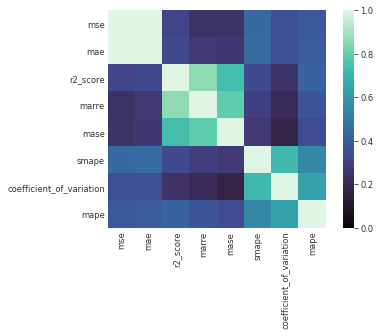

In [13]:

corr_array = np.array(df_metrics.corr(method='spearman'))
np.fill_diagonal(corr_array, np.nan)

metric_sort_inds = np.argsort(np.nanmedian(corr_array, axis=0))[::-1]
metric_sort_inds = np.argsort(np.nanmax(corr_array, axis=0))[::-1]
df_metrics_sorted = df_metrics.iloc[:, metric_sort_inds]


ax = sns.heatmap(df_metrics_sorted.corr(method='spearman'), cmap="mako", vmin=0, vmax=1)
ax.set_aspect('equal')
ax.tick_params(axis='both', which='both', length=0)

# dg.better_savefig("../private_writing/fig_resources/metric_map.png", dpi=600)

### Compare to mathematical properties

In [73]:
chosen_metric = "smape"
models_df = dict()
metrics_df = dict()
for equation_name in all_results:
    models_df[equation_name] = dict()
    metrics_df[equation_name] = dict()
    for model_name in all_results[equation_name]:
        if model_name == "values": continue
        models_df[equation_name][model_name] = all_results[equation_name][model_name][chosen_metric]
    
        for metric_name in all_results[equation_name]["ARIMA"]:
            if metric_name == "prediction": continue
            metrics_df[equation_name][metric_name] = all_results[equation_name]["NBEATSModel"][metric_name]
    
    
models_df = pd.DataFrame(models_df).transpose()
metrics_df = pd.DataFrame(metrics_df).transpose()

In [8]:
attributes =  ['maximum_lyapunov_estimated', 'kaplan_yorke_dimension', 'pesin_entropy', 'correlation_dimension']
all_properties = dict()
for equation_name in get_attractor_list():
    eq = getattr(dysts.flows, equation_name)()
    attr_vals = [getattr(eq, item) for item in attributes]
    
    all_properties[equation_name] = dict(zip(attributes, attr_vals))
    
all_properties = pd.DataFrame(all_properties).transpose()

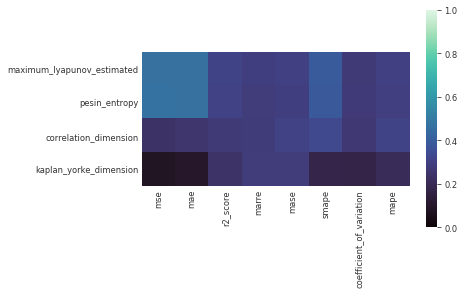

In [94]:
cross_corr = pd.concat([metrics_df, all_properties], axis=1, keys=['metrics_df', 'all_properties']).corr(method="spearman").loc['metrics_df', 'all_properties']
math_sort_inds = np.argsort(np.nanmax(cross_corr, axis=0))[::-1]
math_sort_inds[[0 ,1]] = math_sort_inds[[1 ,0]]

ax = sns.heatmap(cross_corr.transpose().iloc[math_sort_inds, metric_sort_inds], cmap="mako", vmin=0, vmax=1)
ax.set_aspect(1)
ax.tick_params(axis='both', which='both', length=0)

# dg.better_savefig("../private_writing/fig_resources/metric_math.png", dpi=600)

In [95]:
8

8

In [81]:

## Easiest and hardest systems
print("Easiest systems: ", np.unique(models_df.idxmin(axis=0), return_counts=True))
print("Hardest systems: ", np.unique(models_df.idxmax(axis=0), return_counts=True))


all_median_names = list()
for key in models_df.keys():
    all_median_names.append(models_df[models_df[key] == models_df[key].quantile(interpolation='nearest')].index[0])
    
print("Middle systems: ", np.unique(all_median_names, return_counts=True))

Easiest systems:  (array(['ArnoldWeb', 'StickSlipOscillator', 'Torus'], dtype=object), array([ 1,  5, 10]))
Hardest systems:  (array(['CellularNeuralNetwork', 'Chua', 'CoevolvingPredatorPrey',
       'DoublePendulum', 'HyperQi', 'LuChen', 'SprottTorus',
       'TurchinHanski'], dtype=object), array([2, 1, 2, 1, 2, 1, 6, 1]))
Middle systems:  (array(['ChenLee', 'Duffing', 'Finance', 'Halvorsen', 'HyperYan',
       'JerkCircuit', 'LorenzStenflo', 'OscillatingFlow', 'Rossler',
       'Rucklidge', 'SprottA', 'SprottF', 'SprottG', 'ThomasLabyrinth'],
      dtype='<U15'), array([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1]))


In [89]:
Torus().maximum_lyapunov_estimated

0.0

In [88]:
SprottG().maximum_lyapunov_estimated

0.03349131570257799

In [87]:
SprottTorus().maximum_lyapunov_estimated

0.29656066211909027

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:166: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")


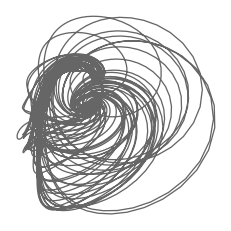

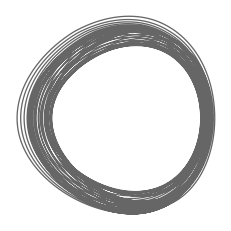

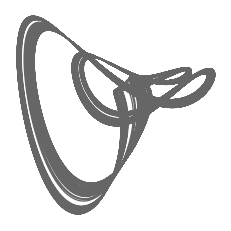

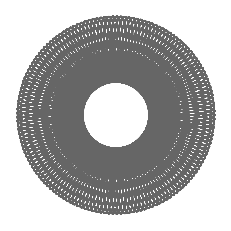

In [86]:
from dysts.flows import SprottTorus, StickSlipOscillator, Torus, SprottG

style1 = {"color": (0.4, 0.4, 0.4)}

plt.figure()
sol = SprottTorus().make_trajectory(50000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/sprott_torus.png", dpi=600)



plt.figure()
sol = StickSlipOscillator().make_trajectory(50000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/stickslip.png", dpi=600)



plt.figure()
sol = SprottG().make_trajectory(50000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/sprottg.png", dpi=600)

plt.figure()
sol = Torus().make_trajectory(50000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/torus.png", dpi=600)

### Compare different forecasting models

In [73]:
# plt.plot(all_results["Halvorsen"]["values"])
# plt.plot(all_results["Halvorsen"]["NBEATSModel"]["prediction"])

In [14]:
import pandas as pd
dflo = pd.DataFrame.from_dict(hist_values_low)
dflo["Granularity"] = "Coarse"
dfhi = pd.DataFrame.from_dict(hist_values_high)
dfhi["Granularity"] = "Fine"
data = pd.merge(dflo, dfhi, how="outer")

all_model_names = np.array(list(hist_values_high.keys()))
all_medians = [np.median(hist_values_high[name]) for name in hist_values_high]
all_means = [np.mean(hist_values_high[name]) for name in hist_values_high]
sort_order = np.argsort(all_medians)
# data = data[all_model_names[sort_order]]

data_long = pd.melt(data, value_vars=all_model_names[sort_order], id_vars="Granularity")

NameError: name 'hist_values_low' is not defined

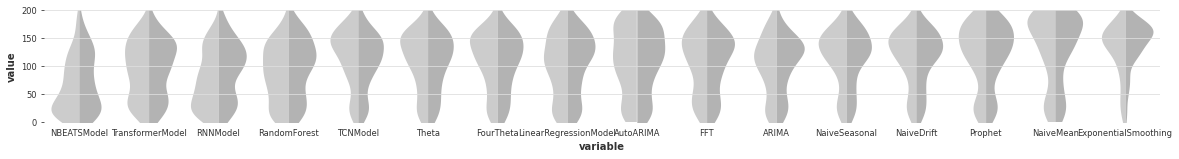

In [10]:
# plt.figure(figsize=(20,10))
# ax = sns.violinplot(data=data_long,  x="variable", y="value", hue="Granularity", 
#                order=all_model_names[sort_order], split=True, scale="area", inner=None, linewidth=0,
#               palette={"Coarse": dg.lighter(dg.gray), "Fine": dg.gray, "linecolor": "w"});
# plt.ylim([0, 200])

# # sns.swarmplot(data=data_long,  x="variable", y="value", hue="Granularity", dodge=True, alpha=0.1, color="k");

# dg.fixed_aspect_ratio(1/10)

# ax.legend_.remove()

# # dg.better_savefig("../private_writing/fig_resources/forecasting_violins.png", dpi=600)

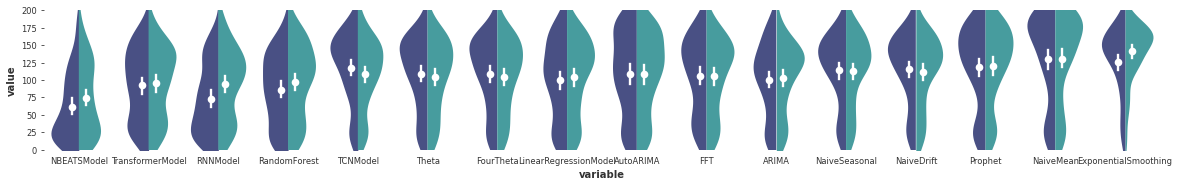

In [127]:
plt.figure(figsize=(20,10))
ax = plt.gca()

# sns.stripplot(ax = ax, data=data_long,  x="variable", y="value", hue="Granularity", jitter=True, order=all_model_names[sort_order],
#               dodge=True, size=3, alpha=0.1, palette="mako")



# ax = sns.boxplot(ax=ax, data=data_long,  x="variable", y="value", hue="Granularity", 
#             palette=["w", "w"], fliersize=False, order=all_model_names[sort_order], linewidth=2)



# ax = sns.swarmplot(data=data_long,  x="variable", y="value", hue="Granularity", order=all_model_names[sort_order],
#               linewidth=0, size=3, alpha=0.1, palette="mako", dodge=True)
# ax = sns.pointplot(data=data_long, x="variable", y="value", hue="Granularity", order=all_model_names[sort_order],
#               linewidth=0, size=4, alpha=0.2, palette="mako", join=False, ci=99, dodge=0.4)



ax = sns.violinplot(data=data_long,  x="variable", y="value", hue="Granularity", order=all_model_names[sort_order],
              linewidth=0, size=3, alpha=0.1, split=True, scale="area", inner=None, palette="mako",
                   )
# for violin in ax.collections[:]:
#     violin.set_alpha(0.25)

# ax = sns.swarmplot(data=data_long,  x="variable", y="value", hue="Granularity", order=all_model_names[sort_order],
#               linewidth=0, size=3, alpha=0.1, palette="mako", dodge=True)
# ax = sns.pointplot(data=data_long, x="variable", y="value", hue="Granularity", order=all_model_names[sort_order],
#               linewidth=0, size=4, alpha=0.2, palette="mako", join=False, ci=99, dodge=0.1)
ax = sns.pointplot(data=data_long, x="variable", y="value", hue="Granularity", order=all_model_names[sort_order],
              linewidth=0, size=4, palette={"Coarse": "w", "Fine": "w"}, join=False, ci=99, dodge=0.2)


plt.ylim([0, 200])
dg.fixed_aspect_ratio(1/8)
ax.grid(False)
ax.legend_.remove()

dg.better_savefig("../private_writing/fig_resources/forecasting_violins.png", dpi=600)

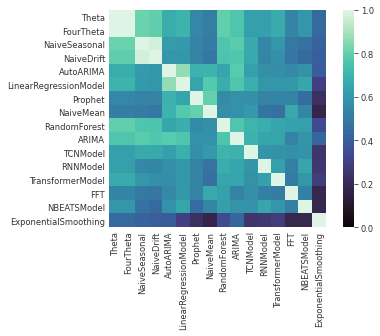

In [17]:


model_records = dict()
for model_name in all_results_transposed.keys():
    model_records[model_name ] = list()
for model_name in all_results_transposed:
    for equation_name in all_results_transposed[model_name]:
        model_records[model_name].append(all_results_transposed[model_name][equation_name]["smape"])
df_models = pd.DataFrame(model_records)


corr_array = np.array(df_models.corr(method='spearman'))
np.fill_diagonal(corr_array, np.nan)

df_models_sorted = df_models.iloc[:, np.argsort(np.nanmedian(corr_array, axis=0))[::-1]]
df_models_sorted = df_models.iloc[:, np.argsort(np.nanmax(corr_array, axis=0))[::-1]]

# df_models_sorted = df_models.iloc[:, sort_order]

ax = sns.heatmap(df_models_sorted.corr(method='spearman'), cmap="mako", vmin=0, vmax=1)
ax.set_aspect('equal')
ax.tick_params(axis='both', which='both', length=0)

# dg.better_savefig("../private_writing/fig_resources/model_correlation_map.png", dpi=600)

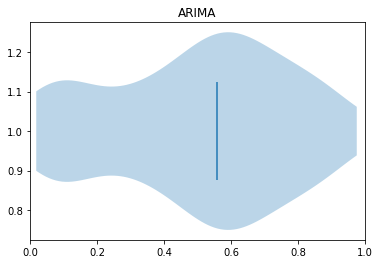

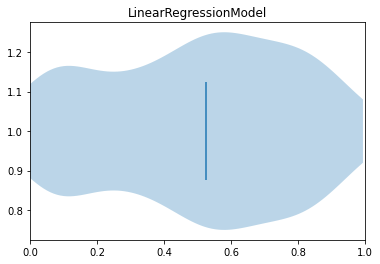

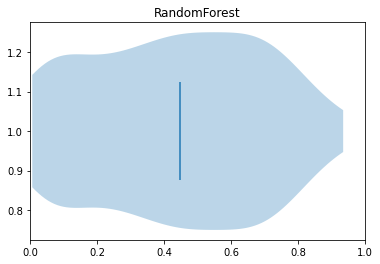

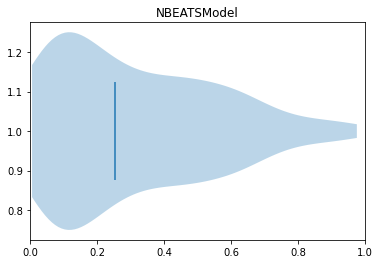

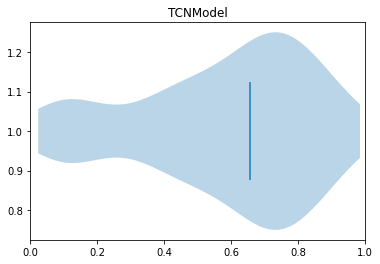

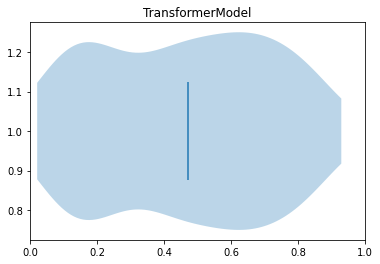

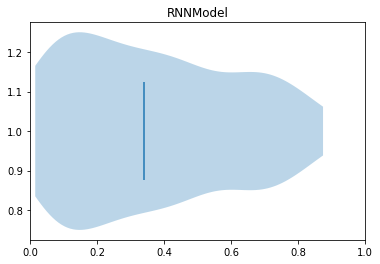

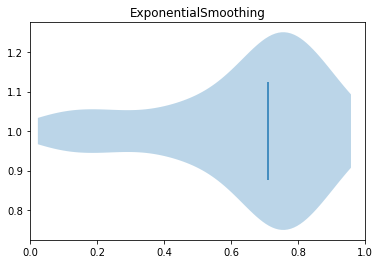

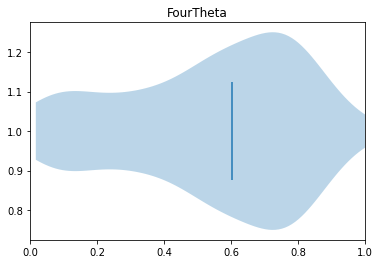

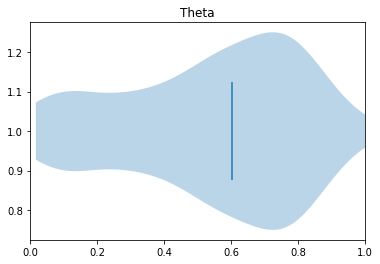

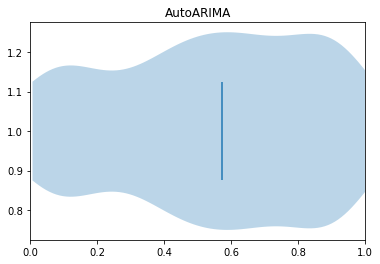

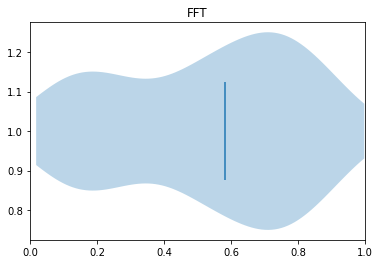

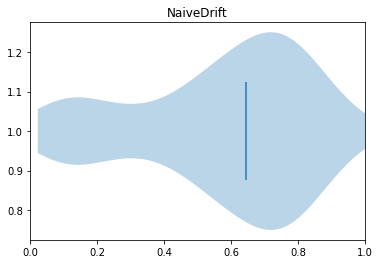

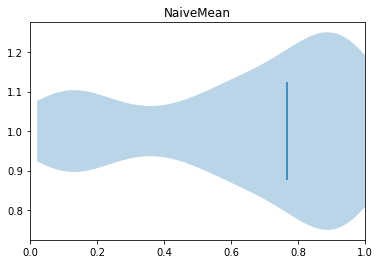

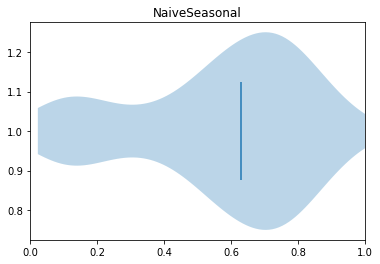

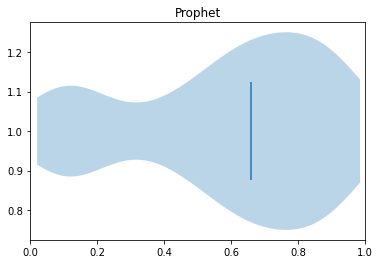

In [73]:
for model_name in hist_values:
    
#     plt.figure()
#     counts = np.array(hist_values[model_name]) / 200.
#     plt.hist(counts, 10, density=True, color="b", alpha=0.5);
#     plt.title(model_name)
#     plt.xlim([0, 1])
#     dg.fixed_aspect_ratio(1/3)


    plt.figure()
    counts = np.array(hist_values[model_name]) / 200.
    plt.violinplot(counts, vert=False, showextrema=False, showmedians=True)
#     plt.hist(counts, 10, density=True, color="b", alpha=0.5);
    plt.title(model_name)
    plt.xlim([0, 1])
#     dg.fixed_aspect_ratio(1/3)


    

In [103]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.bats import BATS
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# y = load_airline()
y_train, y_test = temporal_train_test_split(train_data, train_size=split_point)
t_train, t_test = temporal_train_test_split(np.arange(len(train_data)), train_size=split_point)
# fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = AutoETS()  # monthly seasonal periodicity
forecaster.fit(pd.Series(y_train))
# y_pred = forecaster.predict(fh)
y_pred = np.array(forecaster.predict(np.arange(len(val))))

In [ ]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    MASE (Mean Absolute Scaled Error)
    """
#     if y_train.ndim == 1: y_train = np.expand_dims(y_train, 1)

    # naive seasonal prediction
    y_train = np.asarray(y_train)
    y_pred_naive = y_train
    
    y_train = np.squeeze(y_train.values())

    # mean absolute error of naive seasonal prediction
    mae_naive = darts.metrics.metrics.mae(y_train[1:], y_train[:-1])

    mae_pred = darts.metrics.metrics.mae(
        y_true, y_pred, horizon_weight=horizon_weight, multioutput=multioutput
    )
    return mae_pred / np.max([mae_naive, 1e-15])


In [200]:
import darts.metrics.metrics
dir(darts.metrics.metrics)

all_metrics = {
    'coefficient_of_variation',
    'mae',
    'mape',
    'marre',
#     'mase', # extremely hard to calculate, since it scales relative to another dataset
    'mse',
#     'ope', # runs into issues with zero handling
    'r2_score',
    'rmse',
    'rmsle',
    'smape'
}

pred_y = TimeSeries.from_dataframe(pd.DataFrame(np.array(all_predictions["TransformerModel"])))
true_y = TimeSeries.from_dataframe(pd.DataFrame(y_train_val[:-1]))

for metric_name in all_metrics:
    if metric_name == "mase":
        metric_func = lambda x, y : darts.metrics.metrics.mase(x, y, insample=train_ts)
    else:
        metric_func = getattr(darts.metrics.metrics, metric_name)
    
    metric_func(true_y, pred_y)
# def compute_all_metrics()

[2021-06-12 05:44:59,836] ERROR | darts.metrics.metrics | ValueError: The series of actual value cannot sum to zero when computing OPE.
ERROR:darts.metrics.metrics:ValueError: The series of actual value cannot sum to zero when computing OPE.


ValueError: The series of actual value cannot sum to zero when computing OPE.

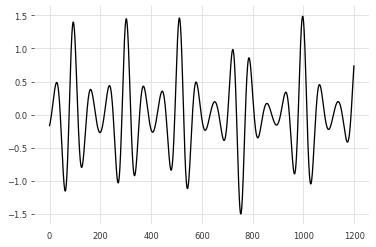

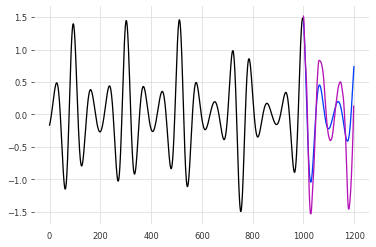

In [142]:
plt.plot(t_train, y_train)
plt.plot(t_train_val, y_train_val)
plt.plot(t_train_val[:-1], all_predictions["TransformerModel"])

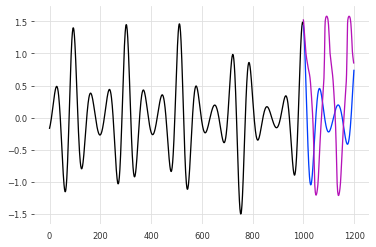

In [140]:
plt.plot(t_train, y_train)
plt.plot(t_train_val, y_train_val)
plt.plot(t_train_val[:-1], all_predictions["TransformerModel"])

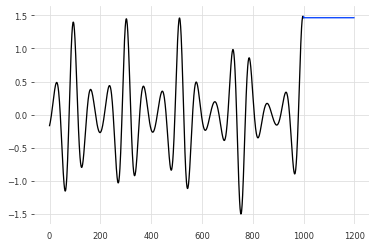

In [124]:
plt.plot(t_train, y_train)
# plt.plot(all_predictions)

# for pred in all_predictions:
plt.plot(t_test[:-1], y_pred)

In [ ]:

names = 
models =
metrics =
benchmark_forecasts = pd.DataFrame

In [ ]:
ModelMode.ADDITIVE

In [3]:
import darts.models

Importing plotly failed. Interactive plots will not work.


In [95]:
all_predictions[0]

IndexError: list index out of range

In [62]:
len(val)

199

In [175]:
 train_data[split_point:].shape

(200,)

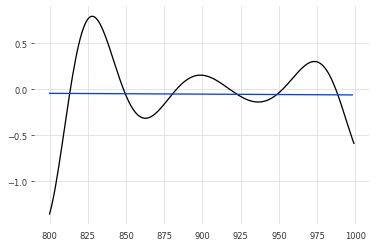

In [190]:
plt.plot(np.arange(split_point, 1000), train_data[split_point:])
plt.plot(np.arange(split_point, 999), all_predictions[-4])

ValueError: x and y must have same first dimension, but have shapes (1000,) and (1200,)

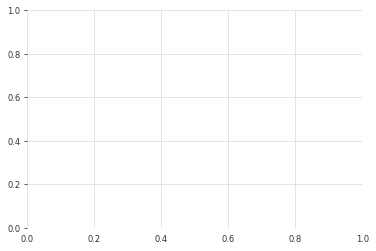

In [123]:
plt.plot(np.arange(1000), train_data)
# plt.plot(all_predictions)

for pred in all_predictions:
    plt.plot(np.arange(split_point, 999), pred)
    


In [34]:
?train_df.split_after

Signature:
train_df.split_after(
    split_point: Union[pandas._libs.tslibs.timestamps.Timestamp, float, int],
) -> Tuple[ForwardRef('TimeSeries'), ForwardRef('TimeSeries')]
Docstring:
Splits the TimeSeries in two, after a provided `split_point`.

Parameters
----------
split_point
    A timestamp, float or integer. If float, represents the proportion of the dataset to include in the
    first TimeSeries (must be between 0.0 and 1.0). If integer, represents the index position after
    which the split is performed. If timestamp, it will be contained in the first TimeSeries, but not
    in the second one. The timestamp may not appear in the original TimeSeries index.

Returns
-------
Tuple[TimeSeries, TimeSeries]
    A tuple of two time series. The first time series contains the first samples up to the `split_point`,
    and the second contains the remaining ones.
File:      ~/miniconda3/envs/nn/lib/python3.8/site-packages/darts/timeseries.py
Type:      method


In [29]:
pd.DataFrame(np.vstack([np.arange(len(train_data)), train_data]).T, columns=["time", "vals"])


,0,1
0,0.0,0.353756
1,1.0,0.353819
2,2.0,0.350929
3,3.0,0.344973
4,4.0,0.335860
...,...,...
995,995.0,-0.389878
996,996.0,-0.441711
997,997.0,-0.492419
998,998.0,-0.541439


In [9]:
from darts import TimeSeries
import pandas as pd
# series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')

                                      0
1970-01-01 00:00:00.000000000  0.353756
1970-01-01 00:00:00.000000001  0.353819
1970-01-01 00:00:00.000000002  0.350929
1970-01-01 00:00:00.000000003  0.344973
1970-01-01 00:00:00.000000004  0.335860
...                                 ...
1970-01-01 00:00:00.000000995 -0.389878
1970-01-01 00:00:00.000000996 -0.441711
1970-01-01 00:00:00.000000997 -0.492419
1970-01-01 00:00:00.000000998 -0.541439
1970-01-01 00:00:00.000000999 -0.588207

[1000 rows x 1 columns]
Freq: N

In [2]:
load_continuous(subsets="train").to_array().shape

(131, 1000)

In [3]:
load_continuous(subsets="test").to_array().shape

(131, 200)

In [4]:
load_continuous(subsets="val").to_array().shape

(131, 200)